## Setting Up Kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !kaggle datasets list -s glove_twitter
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip /content/fake-and-real-news-dataset.zip

!kaggle datasets download -d ruchi798/source-based-news-classification
!unzip /content/source-based-news-classification.zip

# Importing Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from bs4 import BeautifulSoup 

import nltk
nltk.download('all')
import pickle as pk

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud, STOPWORDS
from string import punctuation
import re, string, unicodedata

import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

## Getting The Dataset

In [ ]:
# true = pd.read_csv("True.csv")
# false = pd.read_csv("Fake.csv")
# news = pd.read_csv('news_articles.csv')
# print('True News Shape:', true.shape)
# print('Fake News Shape:', false.shape)
# print('News Article Shape', news.shape)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/Constraint_English_Train - Sheet1.csv")
val = pd.read_csv("/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/Constraint_English_Val - Sheet1.csv")
test = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/english_test_with_labels - Sheet1.csv')
print('True News Shape:', train.shape)
print('Fake News Shape:', val.shape)
print('News Article Shape', test.shape)

True News Shape: (6420, 3)
Fake News Shape: (2140, 3)
News Article Shape (2140, 3)


## Preprocessing

In [ ]:
# Marking Category for True and Fake News
# true['category'] = 1
# false['category'] = 0

# # Merging the 2 Datasets for Preprocessing
# df = pd.concat([true, false])
# print(df.shape)
# sns.countplot(df.category)

### Checking Null Values and Categorical Variables

In [ ]:
test.isnull().sum(), #news.isnull().sum()

(id       0
 tweet    0
 label    0
 dtype: int64,)

In [ ]:
df.subject.value_counts(); #news.dropna(inplace = True)

### Adding Text and Title Row to get One Complete Text Row

In [ ]:
train.label = train.label.replace(['real', 'fake'], [1, 0])
val.label = val.label.replace(['real', 'fake'], [1, 0])
test.label = test.label.replace(['real', 'fake'], [1, 0])
train = train.append([val, test])
df = train[['tweet', 'label']]
df = df.rename(columns = {'tweet' : 'text', 'label' : 'category'})
df.head()

,text,category
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/data.csv')

In [ ]:
# df['text'] = df['text'] + " " + df['title']
# news['text'] = news['text_without_stopwords'] + ' ' + news['title_without_stopwords']
# news['category'] = news['label']

# # Dropping all Unnecessary Columns
# df.drop(['subject', 'title', 'date'], axis = 1, inplace = True)
# # news = news[['text', 'category']]
# # df = df.append(news)

# print(df.shape)
# df.head()

In [ ]:
print(df.shape)
df = df[df['text'].str.split().str.len() <= 100]
df.isnull().sum(), df.shape

(10700, 2)


(text        0
 category    0
 dtype: int64, (10689, 2))

### Cleaning The Data

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
lem = WordNetLemmatizer()

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(lem.lemmatize(i.strip()))
    return " ".join(final_text)

def remove_emojis(text):
    emojis = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return emojis.sub(r'', text)

#Removing the noisy text
def denoise_text(text):
    # Remove Emojis
    text = remove_emojis(text)

    # Remove HTML
    text = strip_html(text)

    # Remove Square Brackets
    text = remove_between_square_brackets(text)

    # Remove Stopwords
    text = remove_stopwords(text)

    return text

# Apply function on review column
df['text'] = df['text'].apply(denoise_text)
df.head()

,text,category
0,CDC currently report 99031 deaths. general dis...,1
1,States reported 1121 death small rise last Tue...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: 1524 #COVID testing labora...,1
4,Populous state generate large case count look ...,1


### WordCloud For Real News

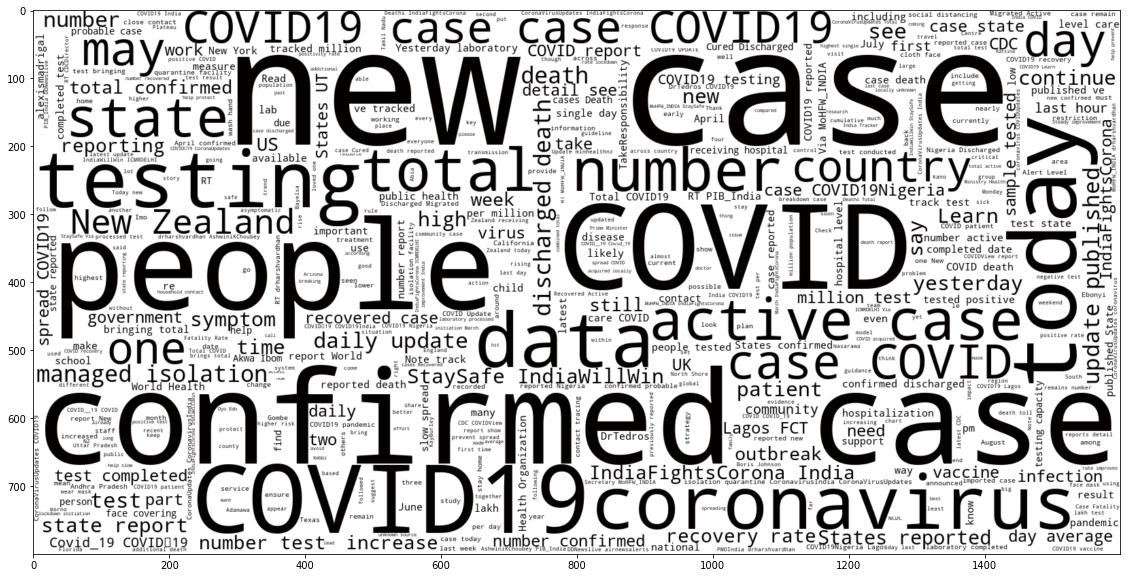

In [ ]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0, 100%, 1%)")

plt.figure(figsize = (20, 10))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS, 
               background_color = 'white' ).generate(" ".join(df[df.category == 1].text))

wc.recolor(color_func = black_color_func)
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
wc.to_file('wcReal.jpg')

### WordCloud for Fake News

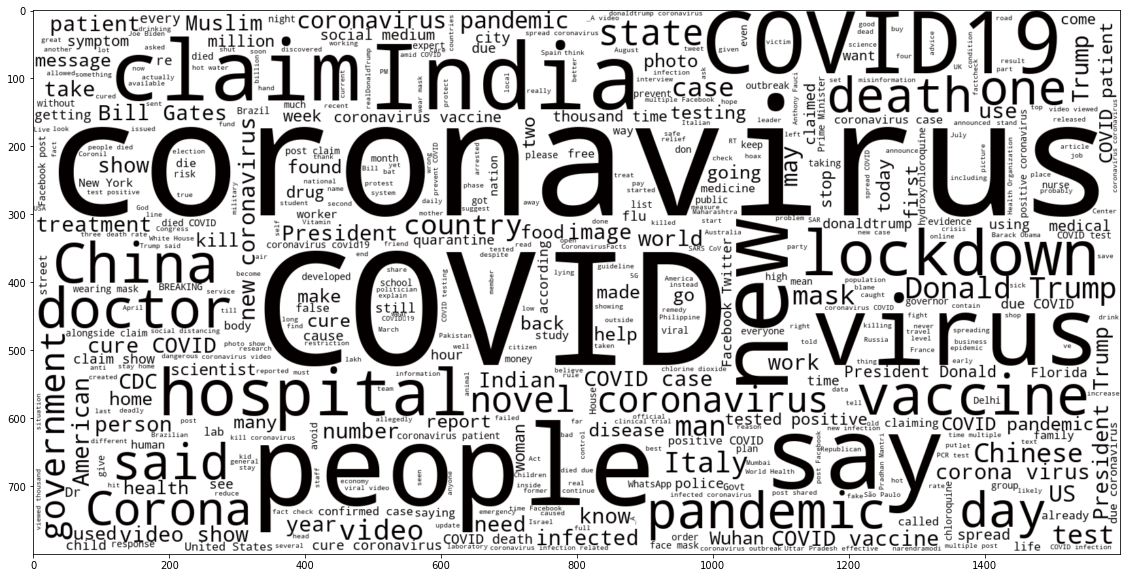

In [ ]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0, 100%, 1%)")

plt.figure(figsize = (20, 10))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS, 
               background_color = 'white' ).generate(" ".join(df[df.category == 0].text))
wc.recolor(color_func = black_color_func)
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
wc.to_file('wcFake.jpg')

### Word Count Distribution

In [ ]:
count_fake = df[df['category'] == 0]['text'].str.split().str.len()
px.histogram(x = count_fake)

In [ ]:
count_fake = df[df['category'] == 1]['text'].str.split().str.len()
px.histogram(x = count_fake)

## Modelling

### Splitting Into Train and Test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.category, test_size = 0.2)
print('Train Data', x_train.shape, y_train.shape)
print('Test Data', x_test.shape, y_test.shape)

Train Data (8551,) (8551,)
Test Data (2138,) (2138,)


### Tokenizing The Texts

In [ ]:
# Maximum Word Limit - 300
max_features = 5000
maxlen = 90

# max_features = 3000
# maxlen = 50

# Assigning Every Word A Number
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x_train)

# Converting train data to numbers according to tokenizer
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen = maxlen)

# Converting test data to numbers according to tokenizer
tokenized_test = tokenizer.texts_to_sequences(x_test)
x_test = sequence.pad_sequences(tokenized_test, maxlen = maxlen)

### Trying With TFIDF

In [ ]:
tfidf = TfidfVectorizer(ngram_range = (1, 2), max_features = 100)
x_train = tfidf.fit_transform(x_train).todense()
x_test = tfidf.transform(x_test).todense()

### Using Glove

In [ ]:
# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype = 'float32')

# EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'    
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
# all_embs = np.stack(embeddings_index.values())
# emb_mean, emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))

# #change below line if computing normal stats is too slow
# embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: 
#       continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: 
#       embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


### Building LSTM Models

In [ ]:
#Defining Neural Network
model = Sequential()

# Non trainable embeddidng layer
model.add(Embedding(2000, output_dim = 100, input_length = 100, trainable = False))

# LSTM Layer 1 
model.add(LSTM(units = 128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))

# LSTM Layer 2
model.add(LSTM(units = 64 , recurrent_dropout = 0.1 , dropout = 0.1))

# Fully Connected Layer 1
model.add(Dense(units = 32 , activation = 'relu'))

# Fully Connected Layer 2
model.add(Dense(1, activation = 'sigmoid'))

# Compiling Model
model.compile(optimizer = keras.optimizers.Adam(lr = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Printing Model Summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          200000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 100, 128)          117248    
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 368,769
Trainable params: 168,769
Non-trainable params: 200,000
_________________________________________________________________


In [ ]:
batch_size = 512
epochs = 5
embed_size = 60
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, 
                                            verbose = 1, factor = 0.5, min_lr = 0.00001)

history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (x_test, y_test), 
                    epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/5
17/17 [==============================] - 18s 803ms/step - loss: 0.6973 - accuracy: 0.5234 - val_loss: 0.6948 - val_accuracy: 0.5108
Epoch 2/5
17/17 [==============================] - 12s 728ms/step - loss: 0.6923 - accuracy: 0.5278 - val_loss: 0.6929 - val_accuracy: 0.5108
Epoch 3/5
17/17 [==============================] - 13s 798ms/step - loss: 0.6919 - accuracy: 0.5266 - val_loss: 0.6933 - val_accuracy: 0.5168
Epoch 4/5
17/17 [==============================] - 13s 758ms/step - loss: 0.6925 - accuracy: 0.5274 - val_loss: 0.6945 - val_accuracy: 0.5108
Epoch 5/5
17/17 [==============================] - 12s 732ms/step - loss: 0.6913 - accuracy: 0.5324 - val_loss: 0.6930 - val_accuracy: 0.5108

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.


### Testing The Model


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train, y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test, y_test)[1]*100 , "%")

1123/1123 [==============================] - 49s 43ms/step - loss: 0.1894 - accuracy: 0.9253
Accuracy of the model on Training Data is -  92.53020882606506 %
281/281 [==============================] - 12s 43ms/step - loss: 0.2009 - accuracy: 0.9212
Accuracy of the model on Testing Data is -  92.11581349372864 %


In [ ]:
# model.save('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/CodaLab90.h5')
# pk.dump(tokenizer, open('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/CodaLab90.pk','wb'))

### Building Pipeline Models

In [ ]:
x_train, x_test = train_test_split(df, test_size = 0.33)

In [ ]:
pipeline_svc = Pipeline([  
        ('tfidf', TfidfVectorizer(ngram_range = (1, 2), max_features = 10000)),  
        ('c', LinearSVC())
    ])

# Fitting the Model
pipeline_svc.fit(x_train['text'], x_train['category'])

# Evaluating Model
pred = pipeline_svc.predict(x_test['text'])
accuracy_score(x_test['category'], pred)

0.9291383219954649

## User Input Checking

In [ ]:
real_text1 = 'Violent protests spread in Bangladesh after Modi visit'
real_text2 = '''A massive blast rocked the port city of Beirut leaving several buildings destroyed and people trapped under the rubble.
As of now the cause of the blast was unknown.

Facts:
:black_medium_square: Lebanon in a political turmoil with tens of thousands protesting.
:black_medium_square:Govt. handling of economic crisis comes under criticism.
:black_medium_square: Covid-19 creates an untenable situation as  food prices double and poor starve.'''

fake_text1 = 'COVID-19 was made in a Chinese lab'
fake_text2 = '''Finally they admit that the COVID-19 Virus does not exist https://bitchute.com/video/9IbspR8lpNR9

So what is going around the world killing some people with low immunity? A genetically modified Pneumonia or TB Bacteria with a higher infectivity rate that was engineered in the Wuhan Labs?

Seems more like the case since thousands across the globe are beating it with antibiotics or anti parasitic drugs.

Then why are these vaccines being forced upon us? To maime or kill people across the globe? Now that too seems to be the case with the increasing number of vaccine damages / deaths across the globe.'''

In [ ]:
''' Our Models '''
# tokenizer = pk.load(open('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/1DHighBias90.pk', 'rb'))
# model = keras.models.load_model('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/90HighBias1D.h5')
pipe = pk.load(open('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/100lenPipelineLem.pk', 'rb'))

# x_user = "👉Alarming Situation 70,000 case in India, 2000 case in Delhi, 1400 case in UP,  499 case in Lucknow, 78 cases found positive in only\
#  one hotel of Rishikah other resorts are being checked, if see one year back we had only 125  case on same day of march, 2020, we were in lock down,\
#   then why we are fearless today. The virus is back, this time with more energy, tactics and camouflage. We don't cough No fever,\
#    it's joint pain, weakness, Loss of appetite and Covid pneumonia! Of course, the death rate is higher, it takes less time to get to the extreme.\
#     Sometimes no symptoms ... let's be careful ... The strain is not domiciled in our nasopharyngeal region! It directly affects the lungs,\
#      which means window periods are shortened. We have seen a number of patients without fever, but an x-ray report shows moderate chest pneumonia!\
#      The nasal swab is often negative for COVID19! 👉 which means that the virus spreads directly to the lungs causing acute respiratory distress\
#       due to viral pneumonia! This explains why it has become acute and more fatal !!! Be careful, avoid crowded places, wear a face mask, wash our\
#        hands often. WAVE more deadly than the FIRST WAVE Please take care and stay safe !"

x_user = '#Gujarat government shuts down two testing laboratories in Surat for issuing fake COVID-19 negative certificates.'

print('\nLength of String is:', len(x_user), '\n')
x_user = denoise_text(x_user)

print('Cleaned Text:', x_user)

max_features = 10000
maxlen = 90

# tokenized_user = tokenizer.texts_to_sequences([x_user])
# x_user = sequence.pad_sequences(tokenized_user, maxlen = maxlen, padding = 'post')

# model.predict(x_user)
pred = pipe.predict([x_user])

# Printing Output
if pred > 0.5: print('\n**Real**')
else: print('\n**Fake**')


Length of String is: 113 

Cleaned Text: #Gujarat government shuts two testing laboratory Surat issuing fake COVID-19 negative certificates.

**Fake**


In [ ]:
# pk.dump(pipeline_svc, open('/content/drive/MyDrive/Natural Language Processing/FakeNewsBot/CodaLab/100lenPipelineLem.pk', 'wb'))

*****

## Miscellaneous Testing

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
a = WordNetLemmatizer()
s = 'Life is very complicate just like nltk that is our stuff and I am the quick brown godzilla'
a.lemmatize(s)

'Life is very complicate just like nltk that is our stuff and I am the quick brown godzilla'

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 133kB 12.4MB/s 


In [ ]:
sent = SentimentIntensityAnalyzer()

In [ ]:
a = 'I am a boy'
sent.polarity_scores(a)

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [ ]:
!pip install google
!pip install rake-nltk

from rake_nltk import Rake
from googlesearch import search
import urllib.request as urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [ ]:
sent = 'coronavirus is being battled by the government'
sent = sent.split('.')
r = Rake()
r.extract_keywords_from_sentences(sent)
print(r.get_ranked_phrases())
put_links = True
query = ' '.join(r.get_ranked_phrases()[:3])

hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}

links, headings = [], []
if query:
  for i in search(query, country='india', lang='en', num=3, start=0, stop=3):
      links.append(i)

  for i in links:
      url = urllib.Request(i, headers = hdr)
      soup = BeautifulSoup(urllib.urlopen(url))
      headings.append(soup.title.get_text())


['coronavirus is being battled by the government']
['government', 'coronavirus', 'battled']
Query: government coronavirus battled
Inside Query https://news.harvard.edu/gazette/story/2020/10/strong-government-response-needed-in-covid-battle/
Inside Query https://www.nytimes.com/interactive/2021/03/01/world/europe/uk-covid-pandemic.html
Inside Query https://www.washingtonpost.com/technology/2020/03/17/white-house-location-data-coronavirus/
Inside Headings https://news.harvard.edu/gazette/story/2020/10/strong-government-response-needed-in-covid-battle/
Inside Headings https://www.nytimes.com/interactive/2021/03/01/world/europe/uk-covid-pandemic.html
Inside Headings https://www.washingtonpost.com/technology/2020/03/17/white-house-location-data-coronavirus/


In [ ]:
a = ' '.join([])
if a: 
  print('1')
else: print('0')

0
